## Problem Background:
* Machine learning techniques are a primary tool for analyzing network traffic and detecting cybersecurity attacks.
* The National Institute of Standards in Technology reported that in 2017, American companies lost 65.6 billion dollars from IT attacks [1].
* Security industry is dependent on costly handling of enormous datasets that is done by hand.
    * Most of today’s machine-learning approaches rely on “anomaly detection,” which tends to trigger false positives
* Therefore, a solution for identifying malicious attacks through a more efficient, effective and lower cost method is greatly needed.

## NSL-KDD Dataset:
* Improved version of the KDD Cup 1999 Dataset
* Does not include the redundant records in the KDD'99 train set
* The classifiers will not be biased towards more frequent records
* The number of records in the train and test sets are reasonable
* No need to randomly select a small portion
* Consists of 1,074,992 distinct records, each of which contains 41 features and is labeled as either normal or as one of four attack types:
    * **Denial of Service Attack (DoS):** denies legitimate users or requests for a machine
    * **User to Root Attack (U2R):** exploits some vulnerability to gain root access to the system
    * **Remote to Local Attack (R2L):** the attacker has the ability to send packets to a machine over a network but does not have an account on that machine and exploits some vulnerability to gain local access as a user of that machine
    * **Probing Attack:** gathers information about a network of computers for the purpose of circumventing security controls   
    
    <br />

* The KDD dataset has three types of features:
    * **Basic Features:** all the attributes that can be extracted from a TCP/IP connection, most of which lead to an implicit delay in detection
    * **Trafﬁc Features:** features that are computed with respect to a window interval, divided into two groups:
        * "Same Host” features: examine only the connections in the past 2 seconds that have the same destination host as the current connection, also calculate statistics related to protocol behavior, service, etc.
        * "Same Service” features: examine only the connections in the past 2 seconds that have the same service as the current connection
    * **Content Features:** features to be able to look for suspicious behavior in the data portion of the packets (R2L and U2R), e.g., number of failed login attempts

## Approach
* What have people already done?
    * AI², which incorporates expert input in a system that combines supervised and unsupervised learning to detect 85% of attacks [2].
    * Chowdhury, et al. displays network information as a graph and automatically identify botnet attack by using clustering algorithms.
    
* What is new in your approach?
    * We will develop our project while holding an unbiased and purely educational perspective. We are not a company with any stake and we are not competing in the competition, so we aren't trying to solve the problem.

* Why do you think you approach can effectively solve the problem?
    * Our goal is purely specific to this data set, so we can take shortcuts and make assumptions


## Part 1: General
Our goals for this section were to:
1. Explore the dataset
2. Establish a baseline for how well we can classify with minimal modifications

In [56]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import sklearn
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [4]:
traindata = pd.read_csv('NSL-KDD/KDDTrain+.csv', header=None)

['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land' 'loadmodule'
 'spy' 'perl']


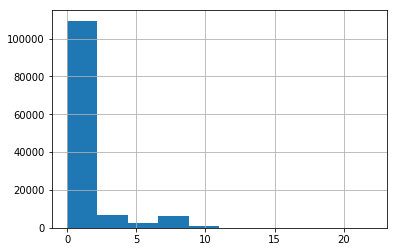

In [5]:
print(traindata[41].unique())
label_map = dict(zip(traindata[41].unique(), range(len(traindata[41].unique()))))
a = traindata.replace(label_map)
a[41].hist()

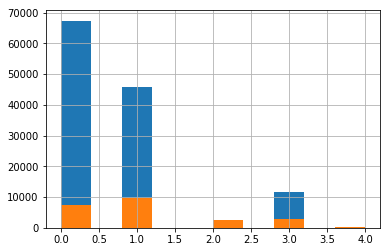

In [10]:
def simplify_label(df):
    attack_dict = {
        'normal': 'normal',

        'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 
        'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',

        'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe',
        'mscan': 'Probe', 'saint': 'Probe',

        'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L', 'phf': 'R2L',
        'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
        'snmpgetattack': 'R2L', 'snmpguess': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'worm': 'R2L',

        'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
        'httptunnel': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R','xterm': 'U2R'
    }

    attack_simp = {}
    for a in df[41].unique():
        if attack_dict[a] is not None:
            attack_simp[a] = attack_dict[a]

    df2 = df.replace(attack_simp)
    label_map = dict(zip(df2[41].unique(), range(len(df2[41].unique()))))
    df2 = df2.replace(label_map)
    return df2

    
traindata = simplify_label(pd.read_csv('NSL-KDD/KDDTrain+.csv', header=None))
testdata = simplify_label(pd.read_csv('NSL-KDD/KDDTest+.csv', header=None))
traindata[41].hist()
testdata[41].hist()

In [11]:
def encode(df):
#     a = df.drop(42, axis=1)
    # Feature 42 is undocumented but we chose to leave it in
    a = df
    protocol_map = dict(zip(df[1].unique(), range(len(df[1].unique()))))
    service_map = dict(zip(df[2].unique(), range(len(df[2].unique()))))
    flag_map = dict(zip(df[3].unique(), range(len(df[3].unique()))))
    # replace the symbolic features
    a = a.replace(flag_map)
    a = a.replace(protocol_map)
    a = a.replace(service_map)
    # replace the labels (22 -> 5)
    label_map = dict(zip(a[41].unique(), range(len(a[41].unique()))))
    a = a.replace(label_map)
    return a

In [12]:
def get_accuracy(train_set, test_set, model):  
    X = train_set.iloc[:,0:41].join(train_set.iloc[:,42])
    Y = train_set.iloc[:,41]
    scaler = Normalizer().fit(X)
    trainX = scaler.transform(X)
    model.fit(X, Y)
    Y_test = test_set.iloc[:,41]
    X_test = test_set.iloc[:,0:41].join(test_set.iloc[:,42])
    scaler = Normalizer().fit(X_test)
    trainX = scaler.transform(X_test)
    predicted = model.predict(X_test)
    return accuracy_score(Y_test, predicted)

In [13]:
train = encode(traindata)
test = encode(testdata)

In [14]:
models = [GaussianNB(), DecisionTreeClassifier(), KNeighborsClassifier(), 
          AdaBoostClassifier(n_estimators=50), AdaBoostClassifier(n_estimators=100), 
          AdaBoostClassifier(n_estimators=150), RandomForestClassifier(n_estimators=50),
          RandomForestClassifier(n_estimators=100), RandomForestClassifier(n_estimators=150)]

acc_list = []
for m in models:
    score = get_accuracy(train, test, m)
    acc_list.append(score)

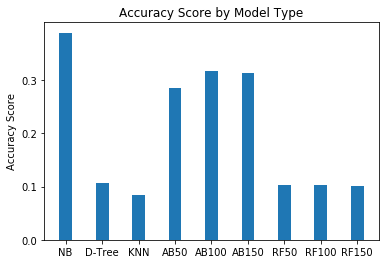

In [15]:
ind = np.arange(len(acc_list))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, acc_list, width)

plt.ylabel('Accuracy Score')
plt.title('Accuracy Score by Model Type')
plt.xticks(ind, ('NB', 'D-Tree', 'KNN', 'AB50', 'AB100', 'AB150', 'RF50', 'RF100', 'RF150'))
plt.yticks(np.arange(0, 0.4, 0.1))

plt.show()
# Note: best = 40%, better than random (25%)

### Part 1 Takeaway:
The AdaBoost classifier was slightly better than randomly selecting a label (25% vs. 20%), however the rest of our models are underperforming.

## Part 2: Specific
* Exploring ways to simplify and boost the accuracy of our best model

In [17]:
# Isolate only DoS labels
def take_DoS(df):
    attack_dict = {}
    for a in df[41].unique():
        attack_dict[a] = False

    attack_dict['normal'] = True
    attack_dict['back'] = True
    attack_dict['land'] = True
    attack_dict['neptune'] = True
    attack_dict['pod'] = True
    attack_dict['smurf'] = True
    attack_dict['teardrop'] = True
    attack_dict['mailbomb'] = True
    attack_dict['apache2'] = True
    attack_dict['processtable'] = True
    attack_dict['udpstorm'] = True    

    a_list = [key for key, value in attack_dict.items() if attack_dict[key] == True]
    a = df[df[41].isin(a_list)]
    return a

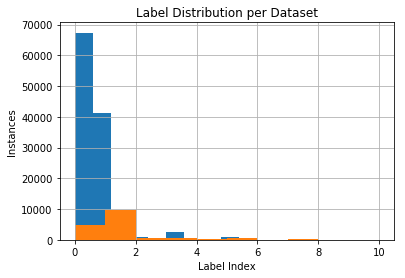

In [19]:
traindata = pd.read_csv('NSL-KDD/KDDTrain+.csv', header=None)
testdata = pd.read_csv('NSL-KDD/KDDTest+.csv', header=None)
train = encode(take_DoS(traindata))
test = encode(take_DoS(testdata))
train[41].hist()
test[41].hist()
plt.ylabel('Instances')
plt.xlabel('Label Index')
plt.title('Label Distribution per Dataset')

plt.show()

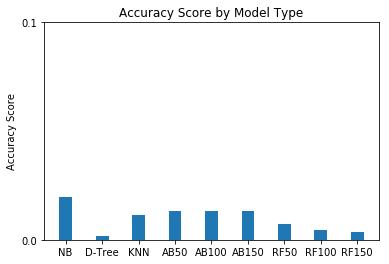

In [25]:
acc_list = []
for m in models:
    score = get_accuracy(train, test, m)
    acc_list.append(score)
    
ind = np.arange(len(acc_list))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, acc_list, width)

plt.ylabel('Accuracy Score')
plt.title('Accuracy Score by Model Type')
plt.xticks(ind, ('NB', 'D-Tree', 'KNN', 'AB50', 'AB100', 'AB150', 'RF50', 'RF100', 'RF150'))
plt.yticks(np.arange(0, max(acc_list)+0.1, 0.1))

plt.show()
# makes sense - 5 labels -> 11 (25% = random vs. 1%)

In [26]:
# Convert to binary - event or no event
def make_binary(df):
    binary_dict = {}
    for label in df[41].unique():
        binary_dict[label] = 0 if label == 'normal' else 1
    a = df.replace(binary_dict)
    return a

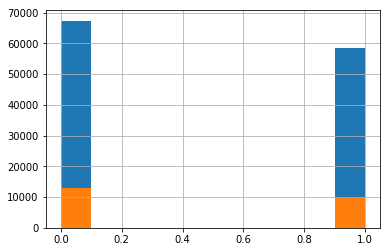

In [27]:
traindata = pd.read_csv('NSL-KDD/KDDTrain+.csv', header=None)
testdata = pd.read_csv('NSL-KDD/KDDTest+.csv', header=None)
train = encode(make_binary(traindata))
test = encode(make_binary(testdata))
train[41].hist()
test[41].hist()

In [28]:
acc_list = []
for m in models:
    score = get_accuracy(train, test, m)
    acc_list.append(score)

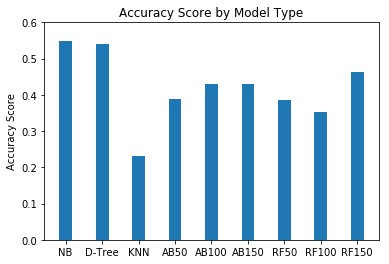

In [29]:
ind = np.arange(len(acc_list))
width = 0.35
p1 = plt.bar(ind, acc_list, width)

plt.ylabel('Accuracy Score')
plt.title('Accuracy Score by Model Type')
plt.xticks(ind, ('NB', 'D-Tree', 'KNN', 'AB50', 'AB100', 'AB150', 'RF50', 'RF100', 'RF150'))
plt.yticks(np.arange(0, max(acc_list) + 0.1, 0.1))

plt.show()
# note - random = 50%, we're performing slightly better

In [30]:
# binary - DoS or no DoS
train = encode(make_binary(take_DoS(traindata)))
test = encode(make_binary(take_DoS(testdata)))

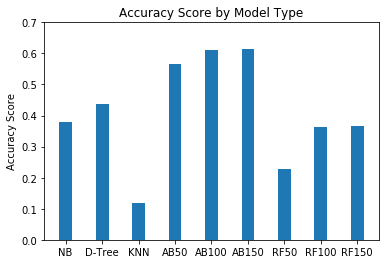

In [31]:
acc_list = []
for m in models:
    score = get_accuracy(train, test, m)
    acc_list.append(score)

p1 = plt.bar(ind, acc_list, width)

plt.ylabel('Accuracy Score')
plt.title('Accuracy Score by Model Type')
plt.xticks(ind, ('NB', 'D-Tree', 'KNN', 'AB50', 'AB100', 'AB150', 'RF50', 'RF100', 'RF150'))
plt.yticks(np.arange(0, max(acc_list) + 0.1, 0.1))

plt.show()
# random = 50%, we're getting 60%

In [33]:
def take_probe(df):
    attack_dict = {}
    for a in df[41].unique():
        attack_dict[a] = False

    attack_dict['normal'] = True
    attack_dict['ipsweep'] = True
    attack_dict['nmap'] = True
    attack_dict['portsweep'] = True
    attack_dict['satan'] = True
    attack_dict['mscan'] = True
    attack_dict['saint'] = True  

    a_list = [key for key, value in attack_dict.items() if attack_dict[key] == True]
    a = df[df[41].isin(a_list)]
    return a

def take_R2L(df):
    attack_dict = {}
    for a in df[41].unique():
        attack_dict[a] = False

    attack_dict['normal'] = True
    attack_dict['ftp_write'] = True
    attack_dict['guess_passwd'] = True
    attack_dict['imap'] = True
    attack_dict['multihop'] = True
    attack_dict['phf'] = True
    attack_dict['spy'] = True  
    attack_dict['warezclient'] = True
    attack_dict['warezmaster'] = True
    attack_dict['sendmail'] = True
    attack_dict['named'] = True
    attack_dict['snmpgetattack'] = True
    attack_dict['snmpguess'] = True
    attack_dict['xlock'] = True 
    attack_dict['xsnoop'] = True
    attack_dict['worm'] = True

    a_list = [key for key, value in attack_dict.items() if attack_dict[key] == True]
    a = df[df[41].isin(a_list)]
    return a

def take_U2R(df):
    attack_dict = {}
    for a in df[41].unique():
        attack_dict[a] = False

    attack_dict['buffer_overflow'] = True
    attack_dict['loadmodule'] = True
    attack_dict['perl'] = True
    attack_dict['rootkit'] = True
    attack_dict['httptunnel'] = True
    attack_dict['ps'] = True
    attack_dict['sqlattack'] = True  
    attack_dict['xterm'] = True
    attack_dict['normal'] = True

    a_list = [key for key, value in attack_dict.items() if attack_dict[key] == True]
    a = df[df[41].isin(a_list)]
    return a

In [34]:
acc_list = []
train = encode(take_DoS(traindata))
test = encode(take_DoS(testdata))
acc_list.append(get_accuracy(train, test, GaussianNB()))

train = encode(take_probe(traindata))
test = encode(take_probe(testdata))
acc_list.append(get_accuracy(train, test, GaussianNB()))

train = encode(take_R2L(traindata))
test = encode(take_R2L(testdata))
acc_list.append(get_accuracy(train, test, GaussianNB()))

train = encode(take_U2R(traindata))
test = encode(take_U2R(testdata))
acc_list.append(get_accuracy(train, test, GaussianNB()))

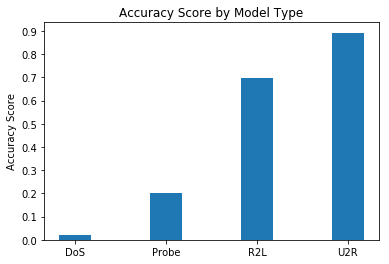

In [42]:
ind = np.arange(len(acc_list))
width = 0.35

p1 = plt.bar(ind, acc_list, width)

plt.ylabel('Accuracy Score')
plt.title('Accuracy Score by Model Type')
plt.xticks(ind, ('DoS', 'Probe', 'R2L', 'U2R'))
plt.yticks(np.arange(0, max(acc_list) + 0.1, 0.1))

plt.show()

In [51]:
# Attempt at making DoS better 
train = pd.read_csv("NSL-KDD/KDDTrain+.csv", header=None)
test = pd.read_csv("NSL-KDD/KDDTest+.csv", header=None)
data = pd.concat([train, test])

In [62]:
data = encode(data)
X = data.iloc[:,0:41]
Y = data.iloc[:,41]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [63]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [64]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
print(accuracy_score(y_test, predictions))

0.992185427761


## Conclusion
* How did we evaluate our approach?
* What are results?
* How did we compare our method to other methods?
* What is your major achievement?
* Future work?